### Libraries and Utilities

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


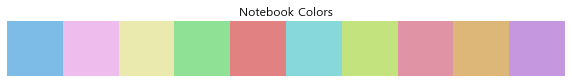

<IPython.core.display.Javascript object>

In [4]:
import os
import warnings
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm, skew
from sklearn.base import clone
from sklearn.pipeline import Pipeline

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_log_error

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

#Visualization
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib import colors
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.subplots import make_subplots

#ML models
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

%matplotlib inline
%load_ext nb_black
warnings.filterwarnings("ignore")
colors = ['#7DBCE6','#EEBDEE','#EAEAAF','#8FE195','#E28181',
          '#87D8DB','#C2E37D','#DF93A4','#DCB778','#C497DE']
sns.palplot(sns.color_palette(colors))
plt.title('Notebook Colors', size=12)
plt.axis('off')
plt.show()

### Load and Check Data

In [6]:
auto = pd.read_csv('./data/auto-mpg.csv')
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


<IPython.core.display.Javascript object>

In [10]:
#차량 브랜드랑 차명 분리하는 전처리 작업
#make -> 차 브랜드 ex) 기아, 현대
#name -> 차 종 ex) k5, k3
#브랜드 축약어를 매핑시켜줘서 풀네임 브랜드로 바꿔줌
def auto_preprocess(dataframe):
    df_ = dataframe.copy()
    auto_misspelled = {'chevroelt': 'chevrolet',
                       'chevy': 'chevrolet',
                       'vokswagen': 'volkswagen',
                       'vw': 'volkswagen',
                       'hi': 'harvester',
                       'maxda': 'mazda',
                       'toyouta': 'toyota',
                       'mercedes-benz': 'mercedes'}
    df_['make'] = [auto_misspelled[key].title() if key in auto_misspelled else 
                key.title() for key in [i.split()[0] for i in df_['car name']]]
    """
    for i in df_['car name']:
        for key in [i.split()[0]]:
            if key in auto_misspelled:
                df_['make'] = auto_misspelled[key].title()
            else:
                df_['make'] = key.title()
    """
    df_['name'] = [' '.join(i.split()[1:]).title() for i in df_['car name']]
    """
    for i in df_['car_name']:
        ' '.join(i.split()[1:]).title()
    """

    df_ = df_.drop(columns = ['car name'], axis = 1)
    return df_

df = auto_preprocess(auto)
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,make,name
0,18.0,8,307.0,130,3504,12.0,70,1,Chevrolet,Chevelle Malibu
1,15.0,8,350.0,165,3693,11.5,70,1,Buick,Skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,Plymouth,Satellite
3,16.0,8,304.0,150,3433,12.0,70,1,Amc,Rebel Sst
4,17.0,8,302.0,140,3449,10.5,70,1,Ford,Torino


<IPython.core.display.Javascript object>

### Variable Types

In [11]:
def check_class(dataframe):
    nunique_df = pd.DataFrame({'Variable' : dataframe.columns,
                               'Classes' : [dataframe[i].nunique() for i in dataframe.columns]})
    nunique_df = nunique_df.sort_values('Classes', ascending = False)
    nunique_df = nunique_df.reset_index(drop = True)
    return nunique_df

check_class(df)

,Variable,Classes
0,weight,351
1,name,300
2,mpg,129
3,acceleration,95
4,horsepower,94
5,displacement,82
6,make,30
7,model year,13
8,cylinders,5
9,origin,3


<IPython.core.display.Javascript object>

In [19]:
def grab_col_names(dataframe, cat_th=10, car_th=20):

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names(df)


Observations: 398
Variables: 10
cat_cols: 2
num_cols: 5
cat_but_car: 3
num_but_cat: 2


<IPython.core.display.Javascript object>

### Descriptive Statistics

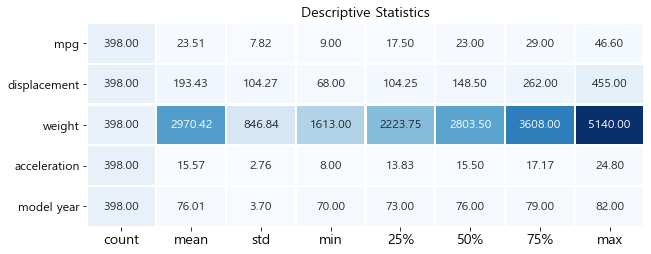

<IPython.core.display.Javascript object>

In [24]:
def desc_stats(dataframe):
    desc = dataframe.describe().T
    f, ax = plt.subplots(figsize=(10, desc.shape[0] * 0.75))
    sns.heatmap(desc, 
                annot = True,
                cmap = 'Blues',
                fmt = '.2f',
                ax = ax,
                linecolor = 'white',
                linewidths = 1.3,
                cbar = False,
                annot_kws = {'size': 12})
    plt.xticks(size = 14)
    plt.yticks(size = 12,
                rotation = 0)
    plt.title("Descriptive Statistics", size = 14)
    plt.show()

desc_stats(df[num_cols])

### Exploratory Data Analysis
#### Analysis of Categorical Variables

In [28]:
def cat_summary(dataframe, col_name):

    def get_labels(x): return x.value_counts().keys()
    def get_values(x): return x.value_counts().values

    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Countplot', 'Percentages'),
                        specs=[[{"type": "xy"}, {'type': 'domain'}]])

    fig.add_trace(go.Bar(y=get_values(dataframe[col_name]).tolist(),
                         x=[str(i)
                            for i in dataframe[col_name].value_counts().index],
                         text=get_values(dataframe[col_name]).tolist(),
                         textfont=dict(size=14),
                         name=col_name,
                         textposition='auto',
                         marker=dict(color=colors),
                         showlegend=False),
                  row=1, col=1)

    fig.add_trace(go.Pie(labels=get_labels(dataframe[col_name]),
                         values=get_values(dataframe[col_name]),
                         textfont=dict(size=14),
                         textposition='auto',
                         showlegend=False,
                         name=col_name,
                         marker=dict(colors=colors)
                         ),
                  row=1, col=2)

    fig.update_layout(title={'text': col_name,
                             'y': 0.9,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='ggplot2')

    iplot(fig)


for col in cat_cols:
    cat_summary(df, col)


<IPython.core.display.Javascript object>

#### Analysis of Numerical Variables

In [29]:
def num_summary(dataframe, col_name):
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Quantiles', 'Distribution'))

    fig.add_trace(go.Box(y=dataframe[col_name],
                         name=str(col_name),
                         showlegend=False,
                         marker_color=colors[1]),
                  row=1, col=1)

    fig.add_trace(go.Histogram(x=dataframe[col_name],
                               xbins=dict(start=dataframe[col_name].min(),
                                          end=dataframe[col_name].max()),
                               showlegend=False,
                               name=str(col_name),
                               marker=dict(color=colors[0],
                                           line=dict(color='#DBE6EC',
                                                     width=1))
                               ),
                  row=1, col=2)

    fig.update_layout(title={'text': col_name,
                             'y': 0.9,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='ggplot2')

    iplot(fig)


for i in num_cols:
    num_summary(df, i)


<IPython.core.display.Javascript object>

#### TOP 10 Horsepower

In [33]:
fig = px.bar(df[['horsepower', 'make', 'name']].
             sort_values('horsepower', ascending=False)[:10],
             y='name',
             x='horsepower',
             text='horsepower',
             labels={'name': '',
                     'horsepower': 'horsepower',
                     'make': ''},
             color='make',
             color_discrete_sequence=colors)

fig.update_layout(title=dict(text='TOP 10 horsepower',
                             x=0.5,
                             y=0.95,
                             xanchor='center',
                             yanchor='top'),
                  xaxis=dict(title='horsepower'),
                  yaxis=dict(categoryorder='total ascending'),
                  font=dict(family='Verdana',
                            size=14,
                            color='gray'),
                  template='ggplot2')

fig.show()


<IPython.core.display.Javascript object>

#### TOP 10 Weight

In [32]:
fig = px.bar(df[['weight', 'make', 'name']].
             sort_values('weight', ascending=False)[:10],
             y='name',
             x='weight',
             text='weight',
             labels={'name': '',
                     'weight': 'Weight',
                     'make': ''},
             color='make',
             color_discrete_sequence=colors)

fig.update_layout(title=dict(text='TOP 10 Weight',
                             x=0.5,
                             y=0.95,
                             xanchor='center',
                             yanchor='top'),
                  xaxis=dict(title='Weight'),
                  yaxis=dict(categoryorder='total ascending'),
                  font=dict(family='Verdana',
                            size=14,
                            color='gray'),
                  template='ggplot2')

fig.show()


<IPython.core.display.Javascript object>

#### Horsepower - MPG - Cylinders

In [34]:
data = [go.Scatter(x=df['mpg'],
                   y=df['horsepower'],
                   mode='markers',
                   text=df['weight'],
                   marker=dict(size=10,
                               color=df['weight'],
                               showscale=True,
                               colorscale='Viridis',
                               colorbar=dict(title='Weight'),
                               opacity=0.8))]

layout = go.Layout(title=dict(text='Horsepower - MPG - Weight',
                              y=0.9,
                              x=0.5,
                              xanchor='center',
                              yanchor='top'),
                   xaxis=dict(title='MPG'),
                   yaxis=dict(title='Horsepower'),
                   template='ggplot2')

fig = go.Figure(data=data, layout=layout)
iplot(fig)


<IPython.core.display.Javascript object>